In [1]:
from collections import defaultdict
import re
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO, Entrez
import py3Dmol

from dotenv import load_dotenv
env_file = '/home/yuan/bio/bio_omics/src/pipelines/.env'
load_dotenv(dotenv_path = env_file)

%load_ext autoreload
%autoreload 2

src_dir = os.path.dirname(os.getcwd())
print('src direcotry is ', src_dir)
bioomics_dir = '/home/yuan/bio/bio_omics/src'
for _dir in (src_dir, bioomics_dir):
    if _dir not in sys.path:
        sys.path.append(_dir)
print(sys.path)

from bioomics import QueryComplex
from plot_region import PlotRegion
from plot_heatmap import PlotHeatmap
from layout import Layout

src direcotry is  /home/yuan/bio/predict_antibody
['/home/yuan/bio/localcolabfold/localcolabfold/colabfold-conda/lib/python310.zip', '/home/yuan/bio/localcolabfold/localcolabfold/colabfold-conda/lib/python3.10', '/home/yuan/bio/localcolabfold/localcolabfold/colabfold-conda/lib/python3.10/lib-dynload', '', '/home/yuan/bio/localcolabfold/localcolabfold/colabfold-conda/lib/python3.10/site-packages', '/home/yuan/bio/predict_antibody', '/home/yuan/bio/bio_omics/src']


In [7]:
# retrieve sequences
query = "select * from view_ab_dssp;"
seq_df = QueryComplex(True).list_data(query, True)
seq_df['specie'] = seq_df['specie'].map(lambda x: x.replace('_', ' '))
seq_df.head(3)

,pdb_id,chain_id,allele_name,specie,gene_name,gene_family,chain_type,avg_bfactor,chain_seq,bfactor,dssp_seq
0,3IJH,3IJH_0_A_0,IGKV8-21*01,Mus musculus,IGKV8-21,IGKV8,K,27.2235,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",--EEEE-SEEEEETT--EEEEEEESS--EETTTTEE-EEEEEE-TT...
1,3IJH,3IJH_0_B_0,IGHV7-3*02,Mus musculus,IGHV7-3,IGHV7,H,29.0730,EVMLVESGGGLVQPGNSLRLSCATSGFTFTDYYMSWVRQPPGKALE...,"52.02,32.13,31.54,28.56,27.2,25.46,28.74,24.8,...",--EEEEE--EEE-TT--EEEEEEEESS-GGGS-EEEEEE-TTS--E...
2,3IJH,3IJH_0_C_0,IGKV8-21*01,Mus musculus,IGKV8-21,IGKV8,K,34.2494,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,"32.95,32.15,27.12,34.57,27.41,31.41,31.04,35.4...",--EEEE-SEEEEETTS-EEEEEEESS--EETTTTEE-EEEEEE-TT...


In [20]:
# IMGT regions
query = f"""select * from align_vfrag
    where pdb_id in (
        select pdb_id from view_antibody
    )
;"""
vregion = QueryComplex(True).list_data(query, True)
vregion['seq_len'] = vregion['seq_to'] - vregion['seq_from'] + 1
vregion.head()

,pdb_id,chain_id,region_name,identity,seq_from,seq_to,seq,seq_len
0,3IJH,3IJH_0_A_0,FR1,96.0,1.0,25.0,IVMTQSPSSLAVSAGEKVTMSCKSS,25.0
1,3IJH,3IJH_0_A_0,CDR1,100.0,26.0,37.0,QSLLNSRTRKNY,12.0
2,3IJH,3IJH_0_A_0,FR2,100.0,38.0,54.0,LAWYQQKPGQSPKLLIY,17.0
3,3IJH,3IJH_0_A_0,CDR2,100.0,55.0,57.0,WAS,3.0
4,3IJH,3IJH_0_A_0,FR3,100.0,58.0,93.0,TRESGVPDRFTGSGSGTDFTLTISSVQAEDLAVYYC,36.0


In [21]:
vregion['region_name'].value_counts()

region_name
Total    32409
FR2      31909
FR3      31569
CDR1     31490
CDR2     31454
FR1      31152
CDR3     29693
Name: count, dtype: int64

In [22]:
df = pd.merge(vregion, seq_df, how='left', on='chain_id')
df.head(3)

,pdb_id_x,chain_id,region_name,identity,seq_from,seq_to,seq,seq_len,pdb_id_y,allele_name,specie,gene_name,gene_family,chain_type,avg_bfactor,chain_seq,bfactor,dssp_seq
0,3IJH,3IJH_0_A_0,FR1,96.0,1.0,25.0,IVMTQSPSSLAVSAGEKVTMSCKSS,25.0,3IJH,IGKV8-21*01,Mus musculus,IGKV8-21,IGKV8,K,27.2235,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",--EEEE-SEEEEETT--EEEEEEESS--EETTTTEE-EEEEEE-TT...
1,3IJH,3IJH_0_A_0,CDR1,100.0,26.0,37.0,QSLLNSRTRKNY,12.0,3IJH,IGKV8-21*01,Mus musculus,IGKV8-21,IGKV8,K,27.2235,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",--EEEE-SEEEEETT--EEEEEEESS--EETTTTEE-EEEEEE-TT...
2,3IJH,3IJH_0_A_0,FR2,100.0,38.0,54.0,LAWYQQKPGQSPKLLIY,17.0,3IJH,IGKV8-21*01,Mus musculus,IGKV8-21,IGKV8,K,27.2235,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",--EEEE-SEEEEETT--EEEEEEESS--EETTTTEE-EEEEEE-TT...


In [38]:
def region_bfactor(row):
    try:
        start, end = int(row['seq_from'])-1, int(row['seq_to'])
        if end > start:
            bfactors = row['bfactor'].split(',')
            return ','.join(bfactors[start:end])
    except Exception as e:
        pass
    return np.nan
df['region_bfactor'] = df.apply(region_bfactor, axis=1)

def region_avg_bfactor(row):
    try:
        start, end = int(row['seq_from'])-1, int(row['seq_to'])
        if end > start:
            bfactors = row['bfactor'].split(',')[start:end]
            return np.mean([float(i) for i in bfactors])
    except Exception as e:
        pass
    return np.nan
df['region_avg_bfactor'] = df.apply(region_avg_bfactor, axis=1)

def region_dssp(row):
    try:
        start, end = int(row['seq_from'])-1, int(row['seq_to'])
        if end > start:
            return row['dssp_seq'][start:end]
    except Exception as e:
        pass
    return np.nan
df['region_dssp'] = df.apply(region_dssp, axis=1)

/home/yuan/bio/localcolabfold/localcolabfold/colabfold-conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuan/bio/localcolabfold/localcolabfold/colabfold-conda/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [40]:
df.head(1).to_dict()

{'pdb_id_x': {0: '3IJH'},
 'chain_id': {0: '3IJH_0_A_0'},
 'region_name': {0: 'FR1'},
 'identity': {0: 96.0},
 'seq_from': {0: 1.0},
 'seq_to': {0: 25.0},
 'seq': {0: 'IVMTQSPSSLAVSAGEKVTMSCKSS'},
 'seq_len': {0: 25.0},
 'pdb_id_y': {0: '3IJH'},
 'allele_name': {0: 'IGKV8-21*01'},
 'specie': {0: 'Mus musculus'},
 'gene_name': {0: 'IGKV8-21'},
 'gene_family': {0: 'IGKV8'},
 'chain_type': {0: 'K'},
 'avg_bfactor': {0: 27.2235},
 'chain_seq': {0: 'IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPGQSPKLLIYWASTRESGVPDRFTGSGSGTDFTLTISSVQAEDLAVYYCKQSNNLRTFGGGTKLEIKRADAAPTVSIFPPSSEQLTSGGASVVCFLNNFYPKDINVKWKIDGSERQNGVLNSWTDQDSKDSTYSMSSTLTLTKDEYERHNSYTCEATHKTSTSPIVKSFNRNE'},
 'bfactor': {0: '26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,20.9,24.85,26.8,28.6,26.87,24.09,26.13,29.88,28.85,28.1,27.09,30.38,24.56,22.98,22.56,23.35,30.53,31.77,27.14,23.7,29.21,33.73,38.68,36.63,31.21,28.71,31.65,22.36,19.18,20.05,19.22,18.84,16.01,19.19,17.58,19.95,25.17,31.4,25.62,23.44,18.04,22.68,18.9,21.82,18.64,18.5

## summary of regions

figure size: 8.5 x 6 cm


<Axes: title={'center': 'Heavy chain'}, xlabel='Length of fragments'>

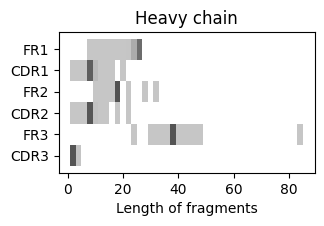

In [26]:
args = {'width_level': 1, 'height': 6}
fig, ax = Layout(args).one()

params = {'specie': 'Homo sapiens', 'chain_type': 'H', 'title': 'Heavy chain'}
PlotRegion(df).hist_region_len(ax, params)

figure size: 8.5 x 6 cm


<Axes: title={'center': 'Lambda chain'}, xlabel='Length of fragments'>

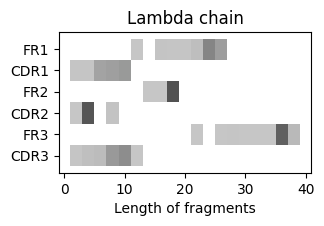

In [27]:
args = {'width_level': 1, 'height': 6}
fig, ax = Layout(args).one()

params = {'specie': 'Homo sapiens', 'chain_type': 'L', 'title': 'Lambda chain'}
PlotRegion(df).hist_region_len(ax, params)

figure size: 8.5 x 6 cm


<Axes: title={'center': 'Kappa chain'}, xlabel='Length of fragments'>

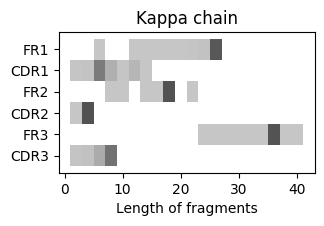

In [28]:
args = {'width_level': 1, 'height': 6}
fig, ax = Layout(args).one()

params = {'specie': 'Homo sapiens', 'chain_type': 'K', 'title': 'Kappa chain'}
PlotRegion(df).hist_region_len(ax, params)

figure size: 17.4 x 5 cm


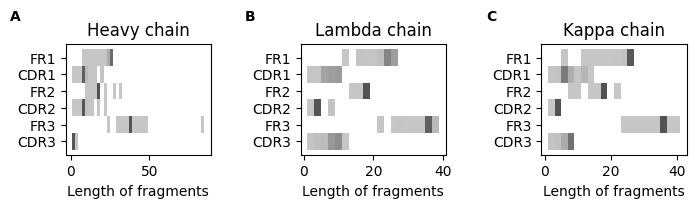

In [33]:
args = {'width_level': 3, 'height': 5, 'space': .15}
label_x = (-40,) * 3
label_y = 25
fig, axes = Layout(args).row(label_x, label_y)

specie = 'Homo sapiens'
params = {'specie': specie, 'chain_type': 'H', 'title': 'Heavy chain'}
PlotRegion(df).hist_region_len(axes[0], params)
params = {'specie': specie, 'chain_type': 'L', 'title': 'Lambda chain'}
PlotRegion(df).hist_region_len(axes[1], params)
params = {'specie': specie, 'chain_type': 'K', 'title': 'Kappa chain'}
PlotRegion(df).hist_region_len(axes[2], params)

fig.savefig(f'{specie}_vregion_fragment.tif', dpi=300, bbox_inches='tight', pad_inches=.05)

## dssp

In [41]:
frags = ['FR1', 'CDR1', 'FR2', 'CDR2', 'FR3', 'CDR3',]
sdf = df[(df['specie']==specie) & (df['region_name'].isin(frags))]
cols = ['chain_type', 'region_name', 'avg_bfactor', 'region_avg_bfactor']
sdf = sdf[cols]
sdf['region_name'] = sdf['region_name'].map(lambda x: x.replace('-IMGT', ''))
sdf

,chain_type,region_name,avg_bfactor,region_avg_bfactor
38,H,FR1,82.9404,94.536800
39,H,CDR1,82.9404,74.080000
40,H,FR2,82.9404,75.563529
41,H,CDR2,82.9404,82.517500
42,H,FR3,82.9404,85.366842
...,...,...,...,...
242084,H,CDR1,254.6500,240.270000
242085,H,FR2,254.6500,219.037647
242086,H,CDR2,254.6500,229.287500
242087,H,FR3,254.6500,249.080789


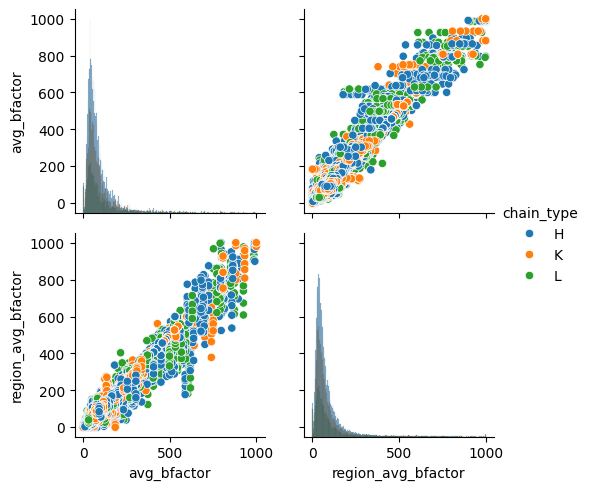

In [42]:
g = sns.PairGrid(sdf, hue='chain_type')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

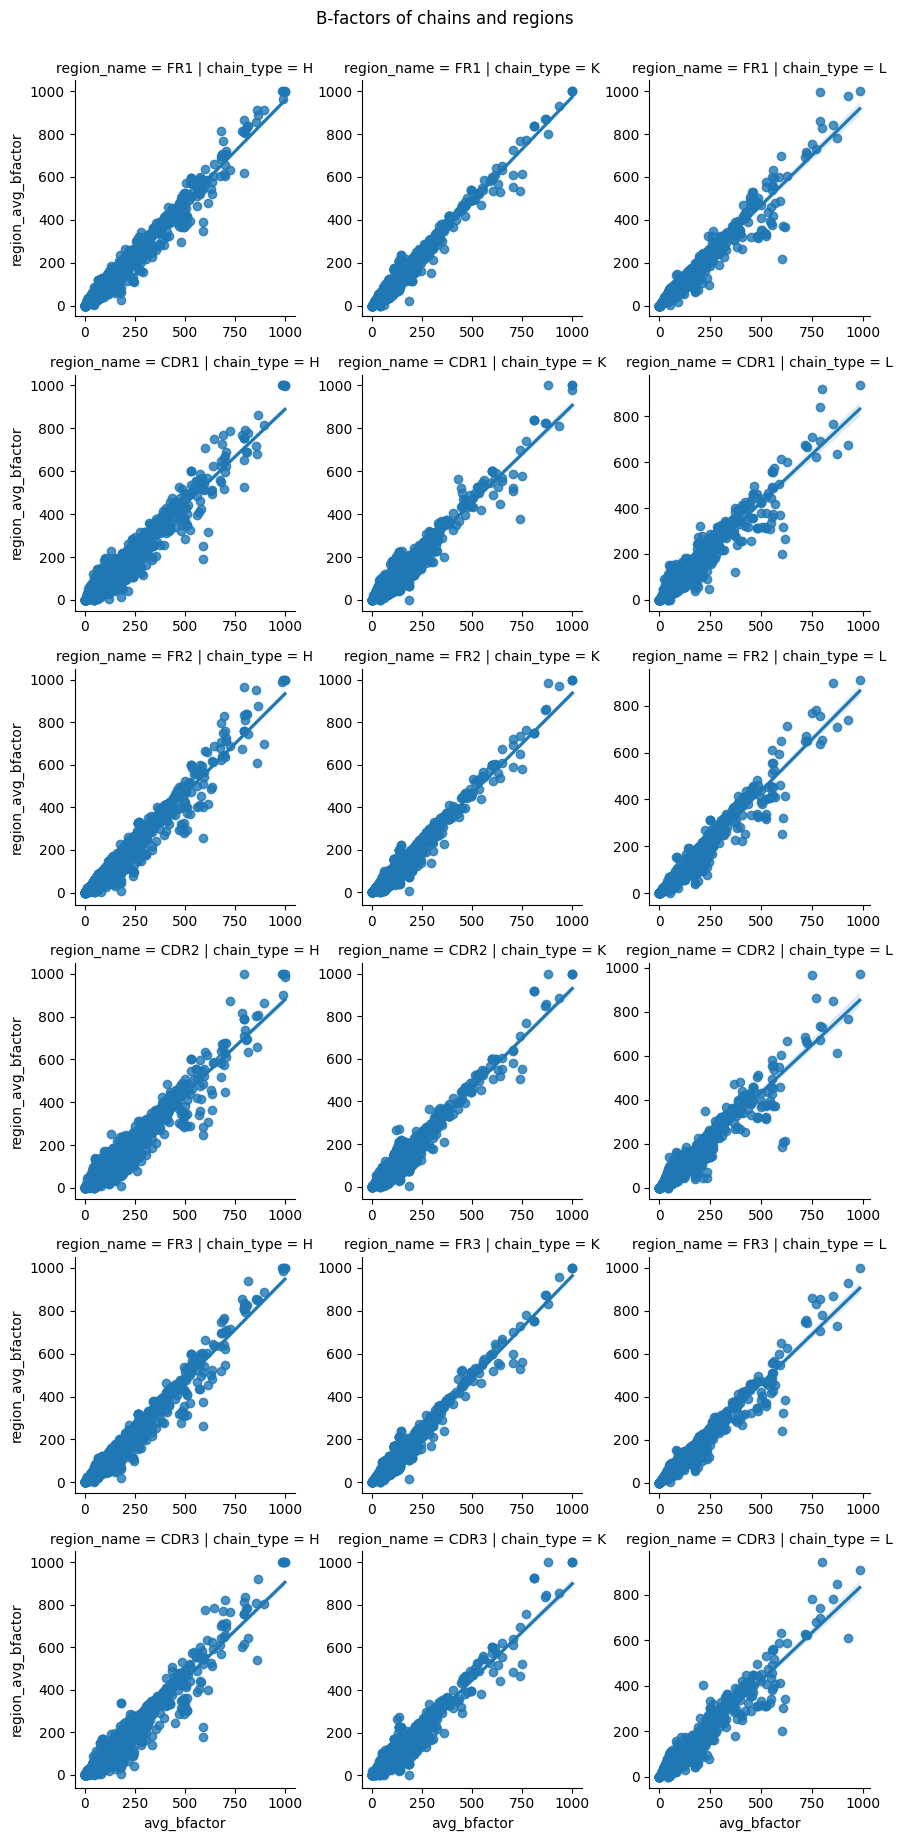

In [43]:
# Create the regression plots with facets
g = sns.lmplot(data=sdf, x="avg_bfactor", y="region_avg_bfactor",
    col="chain_type", row="region_name",
    height=3, facet_kws=dict(sharex=False, sharey=False),
)
g.fig.suptitle("B-factors of chains and regions", y=1.02)

plt.show()

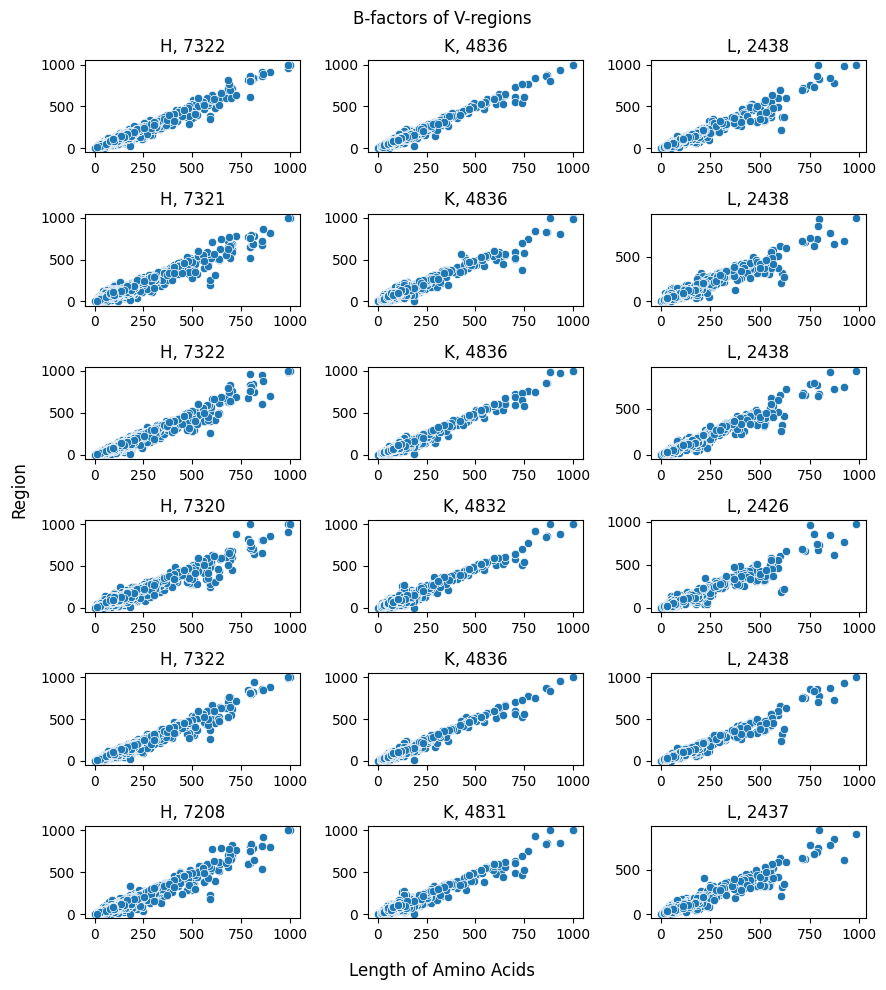

In [44]:
fig, ax = plt.subplots(6,3, figsize=(9,10), layout='tight')
fig.suptitle("B-factors of V-regions")
fig.supxlabel('Length of Amino Acids')
fig.supylabel('Region')

region_names = sdf['region_name'].unique()
chain_types = sdf['chain_type'].unique()
for i, region_name in enumerate(region_names):
    for j, chain_type in enumerate(chain_types):
        sub = sdf[(sdf['region_name']==region_name)&(sdf['chain_type']==chain_type)]
        sns.scatterplot(sub, x='avg_bfactor', y='region_avg_bfactor', ax=ax[i][j])
        ax[i][j].set_title(f"{chain_type}, {len(sub)}")
        ax[i][j].set_xlabel(None)
        ax[i][j].set_ylabel(None)
plt.show()

## secondary structure

In [51]:
chain_types = {'H':'Heavy', 'K':'Kappa', 'L':'Lambda',}
DSSP_CODES ={
    'H': 'alpha helix',
    'B': 'beta bridge', #isolated beta bridge
    'E': 'beta sheet',
    'S': 'bend',  #local, sharp turn 
    'G': '310 helix',
    'I': 'Pi helix',
    'T': 'turn', #hydrogen-bonded turn
    'C': 'coil',
    '-': 'loop',
}
frags = ['FR1', 'CDR1', 'FR2', 'CDR2', 'FR3', 'CDR3',]

In [53]:
pool = []
for i, row in df.iterrows():
    try:
        basic = {
            'region_name': row['region_name'],
            'specie': row['specie'],
            'chain_type': chain_types.get(row['chain_type']),
        }
        if row['region_name'] in frags:
            region_bfactor = row['region_bfactor'].split(',')
            region_dssp = list(row['region_dssp'])
            for b, d in zip(region_bfactor, region_dssp):
                rec = {
                    'bfactor': float(b),
                    'dssp': DSSP_CODES.get(d, 'loop'),
                }
                rec.update(basic)
                pool.append(rec)
    except Exception as e:
        pass
ddf = pd.DataFrame(pool)
ddf.head(1)

,bfactor,dssp,region_name,specie,chain_type
0,26.46,loop,FR1,Mus musculus,Kappa


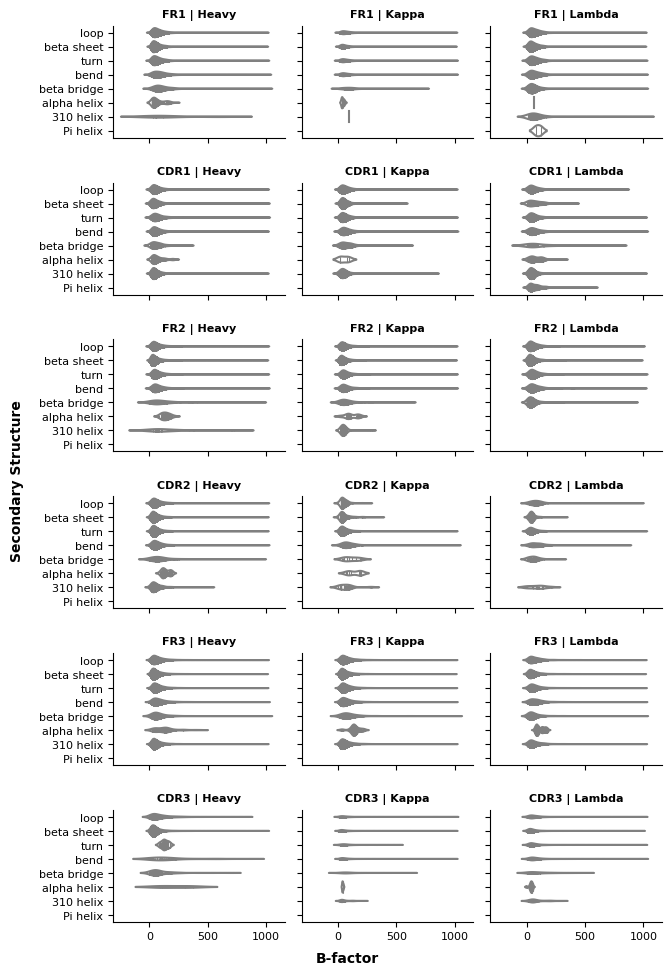

In [54]:
# B-factor distribution
specie = "Homo sapiens"
sddf = ddf[ddf['specie']==specie]

g = sns.FacetGrid(sddf, col='chain_type', row='region_name')
g.map_dataframe(sns.violinplot, y='dssp', x='bfactor',  color='grey', fill=False, inner='stick')
g.set_titles(col_template="{col_name}", row_template="{row_name}", size=8, fontweight='bold')
g.set(xlabel=None, ylabel=None)
g.fig.text(0.5, -0.01, 'B-factor', ha='center', rotation='horizontal', fontsize=10, fontweight='bold')
g.fig.text(-.02, 0.5, 'Secondary Structure', va='center', rotation='vertical', fontsize=10, fontweight='bold')
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=8)

g.fig.subplots_adjust(hspace=.4, wspace=.1)
g.fig.set_size_inches(16.5/2.54, 24/2.54)
g.savefig(f'../figures/{specie}_dssp_bfactor_distribution.tif', dpi=300)

### percentage of DSSP in fragements of v-region

In [58]:
df.head(1)

,pdb_id_x,chain_id,region_name,identity,seq_from,seq_to,seq,seq_len,pdb_id_y,allele_name,...,gene_name,gene_family,chain_type,avg_bfactor,chain_seq,bfactor,dssp_seq,region_bfactor,region_avg_bfactor,region_dssp
0,3IJH,3IJH_0_A_0,FR1,96.0,1.0,25.0,IVMTQSPSSLAVSAGEKVTMSCKSS,25.0,3IJH,IGKV8-21*01,...,IGKV8-21,IGKV8,K,27.2235,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",--EEEE-SEEEEETT--EEEEEEESS--EETTTTEE-EEEEEE-TT...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",26.1024,--EEEE-SEEEEETT--EEEEEEES


In [62]:
# count secondar structure by AA
dssp_pool = {}
len_pool = {}
for i, row in df.iterrows():
    try:
        if row['region_name'] in frags:
            region_name = row['region_name']
            specie = row['specie']
            chain_type = chain_types.get(row['chain_type'])
            seq_len = len(row['seq'])
            key = (specie, chain_type, region_name)
            if key not in len_pool:
                len_pool[key] = {}
            if 'total_len' not in len_pool[key]:
                len_pool[key]['total_len'] = 0
            if 'num_chain' not in len_pool[key]:
                len_pool[key]['num_chain'] = 0
            len_pool[key]['total_len'] += seq_len
            len_pool[key]['num_chain'] += 1
            # split by AA
            region_dssp = list(row['region_dssp'])
            for d in region_dssp:
                d = DSSP_CODES.get(d, 'loop')
                if key not in dssp_pool:
                    dssp_pool[key]= {}
                if d not in dssp_pool[key]:
                    dssp_pool[key][d] = 0
                dssp_pool[key][d] +=1
    except Exception as e:
        # print(e)
        pass

In [63]:
gdf1 = pd.DataFrame.from_dict(dssp_pool, orient='index')
gdf2 = pd.DataFrame.from_dict(len_pool, orient='index')
gdf2 = gdf2.loc[gdf1.index]
gdf = gdf1.div(gdf2['total_len'], axis=0)*100
gdf = gdf.fillna(0)
gdf = gdf.stack().reset_index()
gdf.columns = ['specie','chain_type','region_name', 'structure', 'percent']
gdf = gdf.sort_values(['specie','chain_type',])
gdf.head()

,specie,chain_type,region_name,structure,percent
328,Bos taurus,Heavy,FR1,loop,23.398480
329,Bos taurus,Heavy,FR1,beta sheet,56.460369
330,Bos taurus,Heavy,FR1,bend,12.595005
331,Bos taurus,Heavy,FR1,turn,7.166124
332,Bos taurus,Heavy,FR1,beta bridge,0.380022


Homo sapiens (144, 5)


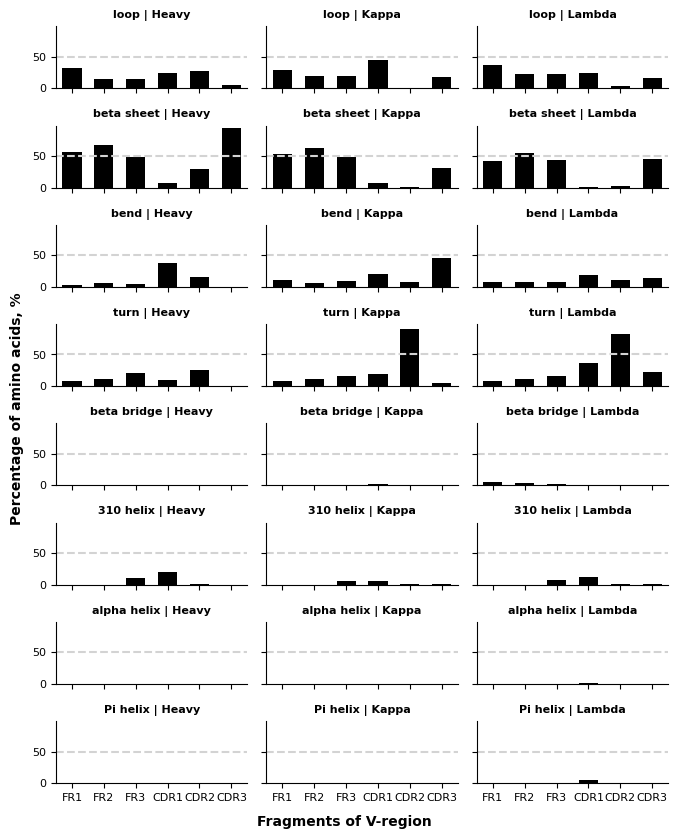

In [69]:
specie = 'Homo sapiens'
g = PlotRegion(gdf).dssp_percent(specie)
g.savefig(f'../figures/{specie}_dssp_percent.tif', dpi=300)

Mus musculus (144, 5)


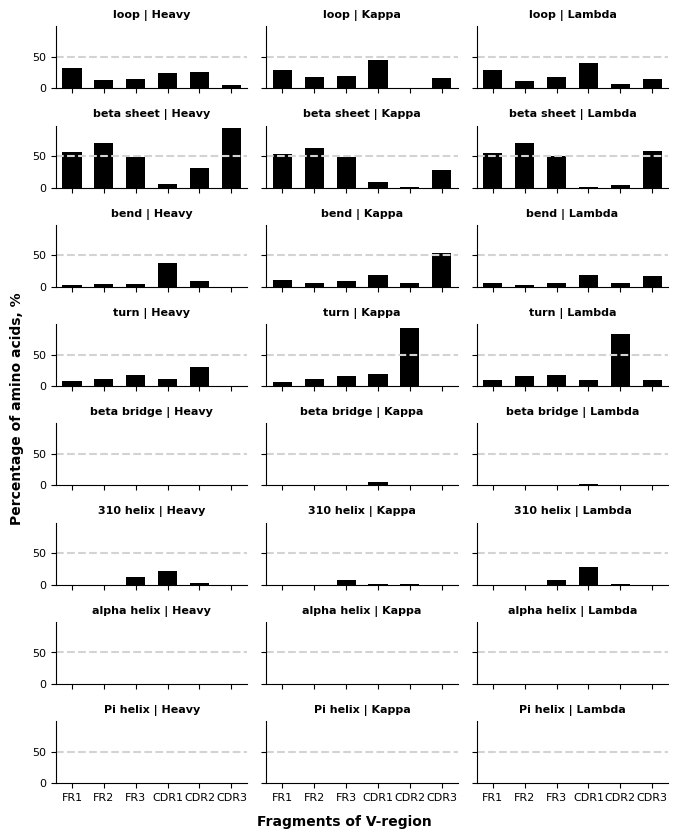

In [68]:
specie = 'Mus musculus'
g = PlotRegion(gdf, True).dssp_percent(specie)
g.savefig(f'../figures/{specie}_dssp_percent.tif', dpi=300)

##  seq vs gene familuy

figure size: 17.4 x 20 cm


<Axes: xlabel='Most abundant gene families', ylabel='Most abundant sequences of CDR1'>

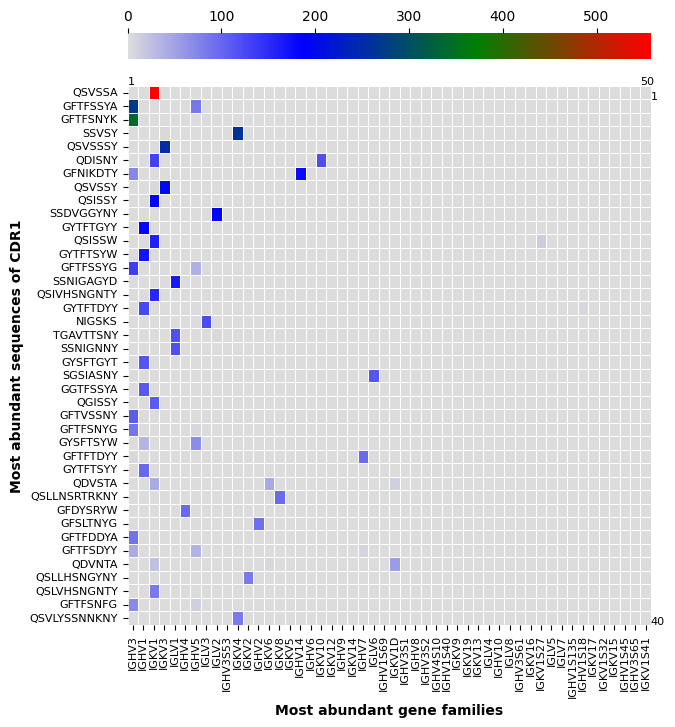

In [71]:
args = {'width_level': 3, 'height': 20}
fig, ax = Layout(args).one()

params = {
    'region_name': 'CDR1',
    'col': 'gene_family', 'row': 'seq',
    'top_col': 50, 'num_row': 40,
    'ylabel': 'Most abundant sequences of CDR1',
    'xlabel': 'Most abundant gene families',
}
PlotHeatmap(df, False).region_seq_abundance(ax, params)

figure size: 17.4 x 20 cm


<Axes: xlabel='Most abundant gene families', ylabel='Most abundant sequences of CDR2'>

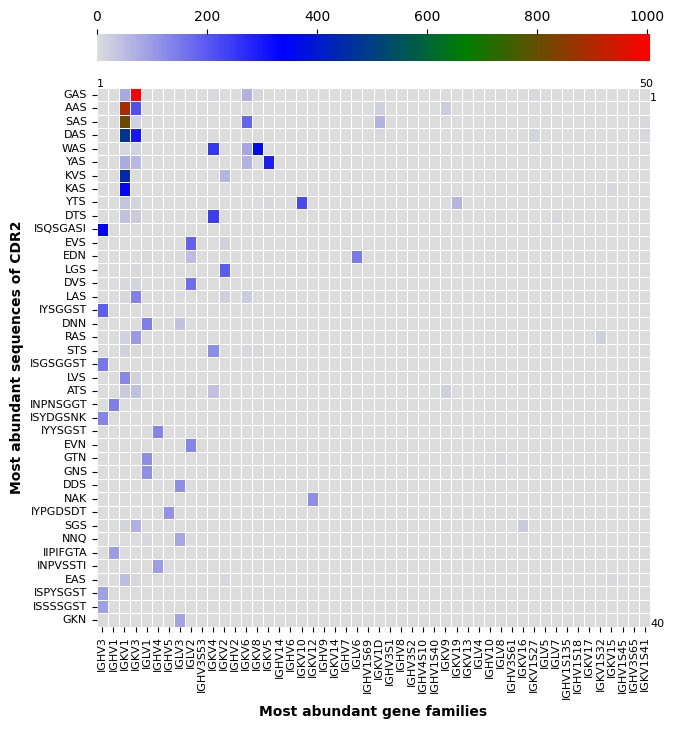

In [72]:
args = {'width_level': 3, 'height': 20}
fig, ax = Layout(args).one()

params = {
    'region_name': 'CDR2',
    'col': 'gene_family', 'row': 'seq',
    'top_col': 50, 'num_row': 40,
    'ylabel': 'Most abundant sequences of CDR2',
    'xlabel': 'Most abundant gene families',
}
PlotHeatmap(df, False).region_seq_abundance(ax, params)

figure size: 17.4 x 20 cm


<Axes: xlabel='Most abundant gene families', ylabel='Most abundant sequences of CDR3'>

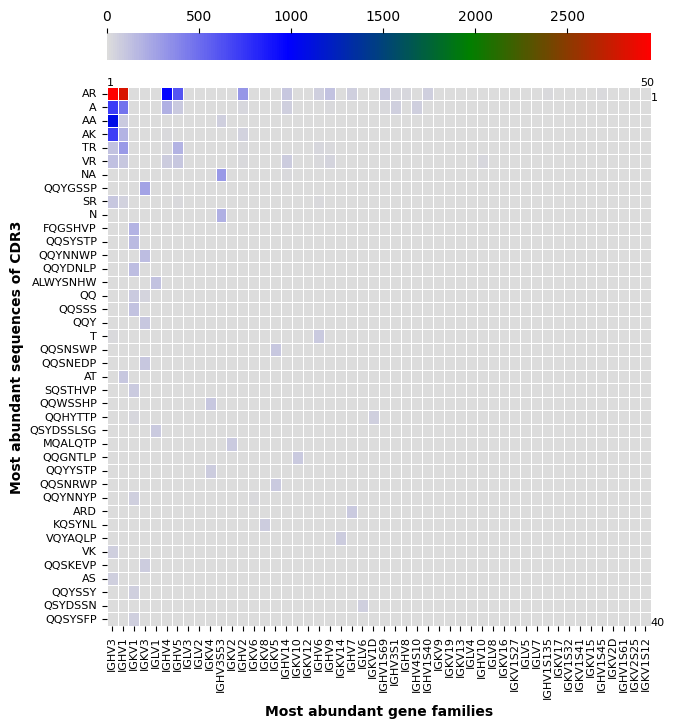

In [73]:
args = {'width_level': 3, 'height': 20}
fig, ax = Layout(args).one()

params = {
    'region_name': 'CDR3',
    'col': 'gene_family', 'row': 'seq',
    'top_col': 50, 'num_row': 40,
    'ylabel': 'Most abundant sequences of CDR3',
    'xlabel': 'Most abundant gene families',
}
PlotHeatmap(df, False).region_seq_abundance(ax, params)

In [742]:
seq = 'MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSAKSELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYK'

seq[136-1:150]

'SRWYNQTPNRAKRVI'

## phylogentics of CDRs

In [74]:
df.head(2)

,pdb_id_x,chain_id,region_name,identity,seq_from,seq_to,seq,seq_len,pdb_id_y,allele_name,...,gene_name,gene_family,chain_type,avg_bfactor,chain_seq,bfactor,dssp_seq,region_bfactor,region_avg_bfactor,region_dssp
0,3IJH,3IJH_0_A_0,FR1,96.0,1.0,25.0,IVMTQSPSSLAVSAGEKVTMSCKSS,25.0,3IJH,IGKV8-21*01,...,IGKV8-21,IGKV8,K,27.2235,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",--EEEE-SEEEEETT--EEEEEEESS--EETTTTEE-EEEEEE-TT...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",26.1024,--EEEE-SEEEEETT--EEEEEEES
1,3IJH,3IJH_0_A_0,CDR1,100.0,26.0,37.0,QSLLNSRTRKNY,12.0,3IJH,IGKV8-21*01,...,IGKV8-21,IGKV8,K,27.2235,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",--EEEE-SEEEEETT--EEEEEEESS--EETTTTEE-EEEEEE-TT...,"31.77,27.14,23.7,29.21,33.73,38.68,36.63,31.21...",29.4975,S--EETTTTEE-


<Axes: xlabel='count', ylabel='seq'>

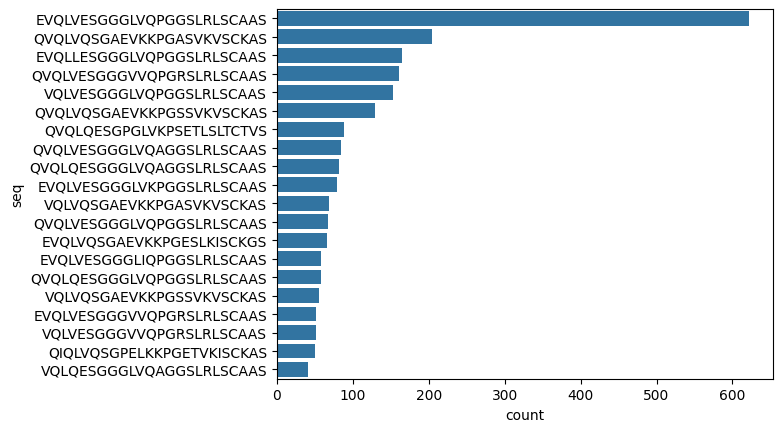

In [75]:
fr1 = df[df['region_name']=='FR1']
fr1 = fr1[['chain_seq', 'chain_type', 'seq']].drop_duplicates()
fr1_freq = fr1.groupby(['chain_type', 'seq']).agg({'chain_seq': len})
fr1_freq = fr1_freq.reset_index().rename(columns={'chain_seq': 'count'})
fr1_freq = fr1_freq.sort_values(by=['chain_type', 'count'], ascending=[True, False])
# fr1_freq.head(10)
topn = 20
values = fr1_freq[fr1_freq['chain_type']=='H']
counts = pd.DataFrame(values.iloc[:topn,1:])
other = sum(values['count'][topn:])
sns.barplot(counts, x='count', y='seq')

<Axes: xlabel='count', ylabel='seq'>

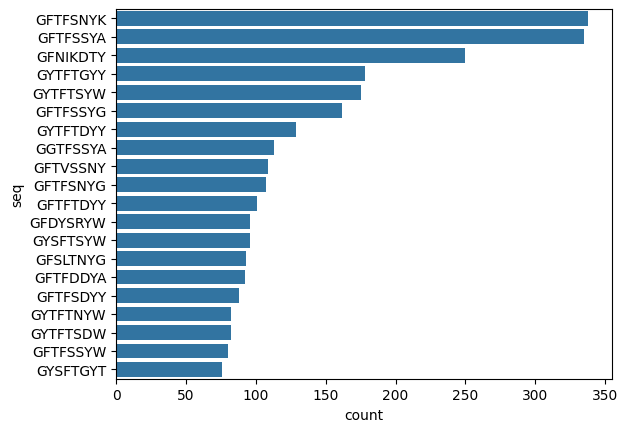

In [76]:
cdr1 = df[df['region_name']=='CDR1']
cdr1 = cdr1[['chain_id', 'chain_type', 'seq']].drop_duplicates()
cdr1_freq = cdr1.groupby(['chain_type', 'seq']).agg({'chain_id': len})
cdr1_freq = cdr1_freq.reset_index().rename(columns={'chain_id': 'count'})
cdr1_freq = cdr1_freq.sort_values(by=['chain_type', 'count'], ascending=[True, False])
# cdr1_freq.head(10)
topn = 20
values = cdr1_freq[cdr1_freq['chain_type']=='H']
counts = pd.DataFrame(values.iloc[:topn,1:])
other = sum(values['count'][topn:])
sns.barplot(counts, x='count', y='seq')

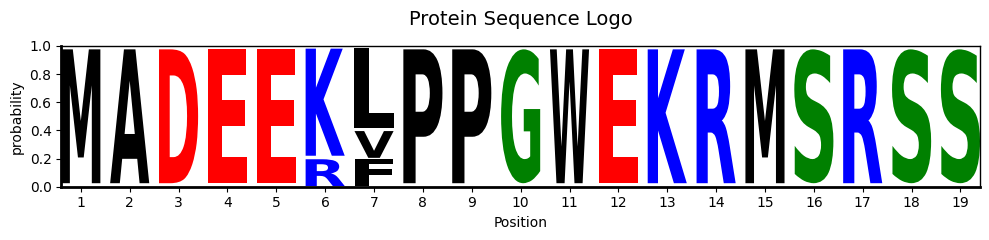

In [587]:
import logomaker
import pandas as pd
import matplotlib.pyplot as plt

# Sample protein sequences
protein_sequences = [
    'MADEEKLPPGWEKRMSRSS',
    'MADEEKFPPGWEKRMSRSS',
    'MADEERLPPGWEKRMSRSS',
    'MADEEKVPPGWEKRMSRSS',
    'MADEEKLPPGWEKRMSRSS'
]

# Create a weight matrix (frequency)
def sequences_to_matrix(seqs):
    """Convert sequences to probability matrix"""
    length = len(seqs[0])
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    
    # Initialize count matrix
    counts = pd.DataFrame(0, index=range(length), columns=list(amino_acids))
    
    # Count occurrences
    for seq in seqs:
        for i, aa in enumerate(seq):
            if aa in counts.columns:
                counts.at[i, aa] += 1
    
    # Convert to frequencies
    total = len(seqs)
    freq_matrix = counts / total
    
    return freq_matrix

# Create frequency matrix
freq_matrix = sequences_to_matrix(protein_sequences)

# Create sequence logo
logo = logomaker.Logo(freq_matrix,
                      color_scheme='chemistry',
                      font_name='DejaVu Sans',
                      stack_order='big_on_top',
                      fade_probabilities=False,
                      vpad=0.05,
                      width=0.8)

# Customize appearance
logo.style_spines(visible=True)
logo.style_spines(spines=['left', 'bottom'], visible=True, linewidth=2)
logo.ax.set_ylabel('probability')
logo.ax.set_xlabel('Position')
logo.ax.set_xticks(range(len(protein_sequences[0])))
logo.ax.set_xticklabels(range(1, len(protein_sequences[0]) + 1))
logo.ax.set_title('Protein Sequence Logo', fontsize=14, pad=15)

plt.tight_layout()
plt.show()

In [586]:
ww_df

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
pos,,,,,,,,,,,,,,,,,,,,
0,0.001592,0.001592,0.001592,0.001592,0.001592,0.001592,0.001592,0.001592,0.001592,4.013830,0.001592,0.001592,0.001592,0.001592,0.001592,0.001592,0.001592,0.068436,0.001592,0.001592
1,0.034975,0.001399,0.001399,0.020985,0.006995,0.012591,0.013990,0.001399,0.006995,0.012591,0.001399,0.012591,3.710129,0.022384,0.004197,0.013990,0.004197,0.002798,0.001399,0.001399
2,0.103247,0.018391,0.090664,0.137448,0.007098,0.020327,0.018714,0.002581,0.024844,0.019681,0.003226,0.020972,0.322647,0.030651,0.013229,0.118089,0.034523,0.011615,0.001291,0.022908
3,0.071196,0.000630,0.127271,0.094508,0.004410,1.462354,0.031503,0.002520,0.020162,0.014491,0.003150,0.153733,0.202247,0.028982,0.006931,0.032133,0.002520,0.010081,0.000630,0.001890
4,0.001046,0.001046,0.001046,0.001046,0.007325,0.001046,0.001046,0.001046,0.001046,0.002093,0.001046,0.001046,0.001046,0.001046,0.002093,0.001046,0.001046,0.002093,4.061442,0.051278
5,0.028139,0.017810,0.021728,0.652546,0.007124,0.007124,0.011398,0.055210,0.127873,0.017097,0.015316,0.008192,0.000356,0.087267,0.056991,0.089048,0.114338,0.085130,0.002493,0.008905
6,0.129428,0.010085,0.002241,0.366712,0.002801,0.003642,0.002801,0.035298,0.103654,0.013167,0.108697,0.000280,0.024093,0.084884,0.090487,0.034458,0.028295,0.071718,0.002241,0.004202
7,0.116421,0.036308,0.007027,0.012181,0.026938,0.018271,0.104006,0.022488,0.037245,0.032795,0.006793,0.006325,0.000234,0.046615,0.294683,0.015695,0.015695,0.062778,0.000234,0.079410
8,0.007131,0.000648,0.003501,0.019189,0.036175,0.001037,0.013095,0.038768,0.055623,0.043176,0.013744,0.003760,0.001556,0.022301,0.040324,0.011929,0.054975,0.065477,0.038768,0.047584
